In [13]:

import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from azureml.telemetry import set_diagnostics_collection
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
import sklearn.metrics 
from azureml.core.experiment import Experiment
import matplotlib.pyplot as plt
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.webservice import Webservice, AksWebservice

### kaggle
datain_dir = './'
datain_col_dir = './'
dataout_dir = ''

### mac
#datain_dir = '~/Data/diabetes/'
#datain_col_dir = '~/Data/diabetes/'
#dataout_dir = '~/Data/diabetes/'

### desktop
#from kaggle import proj #desktop
#datain_dir = proj.data_dir #desktop

In [10]:
import azureml.core
import os
from azureml.core import Workspace

subscription_id = os.getenv("SUBSCRIPTION_ID", default="a6c2a7cc-d67e-4a1a-b765-983f08c0423a")
resource_group = os.getenv("RESOURCE_GROUP", default="xiaoyzhu-mlworkspace")
workspace_name = os.getenv("WORKSPACE_NAME", default="xiaoyzhu-MLworkspace")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")


try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config(file_name="xiaoyzhuconfig.json")
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except:
    print("Workspace not accessible. Change your parameters or create a new workspace below")

Falling back to use azure cli credentials. This fall back to use azure cli credentials will be removed in the next release. 
Make sure your code doesn't require 'az login' to have happened before using azureml-sdk, except the case when you are specifying AzureCliAuthentication in azureml-sdk.


Wrote the config file xiaoyzhuconfig.json to: F:\PatientHub\MLModels\Diabetes\aml_config\xiaoyzhuconfig.json
Workspace configuration succeeded. Skip the workspace creation steps below


In [11]:
import numpy as np

# Read in the data

In [127]:
df_raw_all = pd.read_csv(datain_dir + 'diabetic_data.csv')
df_raw = df_raw_all
df_raw = df_raw.replace('?', np.nan) 
df_raw.shape

(101766, 50)

In [128]:
df_raw.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

# How many values are missing in patient records?

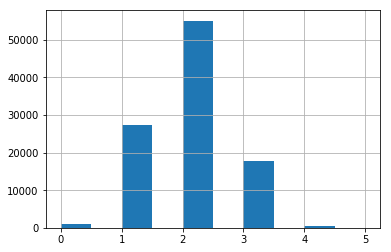

In [129]:
pt_sparsity = df_raw.isnull().apply(sum, axis=1)
%matplotlib inline
myhist = pt_sparsity.hist()

No need to drop patients due to missing values. 3 out of 50 missing values is not bad at all.

# Explore the variables, compile information about them

In [130]:
col_data = df_raw.apply(lambda s: set(s.unique()), axis=0).to_frame('uni_val')
col_data['nan_rat'] = df_raw.isnull().sum(axis=0)/len(df_raw)
col_data['n_uni_vals'] = col_data.uni_val.apply(len)
col_data['uni_vals_str'] = col_data[col_data.n_uni_vals<2000].uni_val.astype(str)
col_data = col_data.drop('uni_val', axis=1)
col_data['var_type'] = np.nan
col_data.to_csv(dataout_dir + "columns_raw.csv")

# Manual annotation of columns
I manually took columns_raw.csv and annotated columns based on whether they were ordered or categorical.  I saved my annotated file as columns.csv.  I will read this in later in the notebook.

In [131]:
col_data = pd.read_csv(datain_col_dir + "columns.csv", index_col=0)
col_data.sample(10)

,nan_rat,n_uni_vals,uni_vals_str,var_type,comment
glyburide-metformin,0.0000,3,"{'Steady', 'Up', 'No'}",cat,NaN
acetohexamide,0.0000,1,{'No'},drop,no information here!
tolazamide,0.0000,2,"{'Steady', 'No'}",cat,NaN
time_in_hospital,0.0000,14,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}",cont,NaN
payer_code,0.3962,17,"{nan, 'HM', 'OG', 'MC', 'DM', 'CM', 'SI', 'MD'...",cat,NaN
number_diagnoses,0.0000,15,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15...",cont,NaN
number_outpatient,0.0000,21,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",cont,NaN
weight,0.9673,8,"{nan, '[50-75)', '[75-100)', '[150-175)', '[10...",drop,too many missing values
num_procedures,0.0000,7,"{0, 1, 2, 3, 4, 5, 6}",cont,NaN
pioglitazone,0.0000,4,"{'Steady', 'Up', 'No', 'Down'}",cat,NaN


# Generate boolean features for only most common medical specialties

In [132]:
#TODO recapture medical specialty
spec_counts = df_raw.medical_specialty.value_counts()
spec_counts.head(5).to_frame('num patients')

,num patients
InternalMedicine,14635
Emergency/Trauma,7565
Family/GeneralPractice,7440
Cardiology,5352
Surgery-General,3099


In [133]:
spec_thresh = 5
for (spec, count) in spec_counts.head(spec_thresh).iteritems():
    new_col = 'spec_' + str(spec)
    df_raw[new_col] = (df_raw.medical_specialty == spec)
    
df_raw.filter(regex='spec').sample(10)

,medical_specialty,spec_InternalMedicine,spec_Emergency/Trauma,spec_Family/GeneralPractice,spec_Cardiology,spec_Surgery-General
60144,NaN,False,False,False,False,False
6531,Family/GeneralPractice,False,False,True,False,False
75831,NaN,False,False,False,False,False
3916,Psychiatry,False,False,False,False,False
21312,InternalMedicine,True,False,False,False,False
67636,NaN,False,False,False,False,False
99928,NaN,False,False,False,False,False
14078,NaN,False,False,False,False,False
49346,NaN,False,False,False,False,False
92121,NaN,False,False,False,False,False


# Identify the most common diagnoses

In [134]:
diag_counts = (df_raw.diag_1.value_counts() + df_raw.diag_2.value_counts() + df_raw.diag_3.value_counts()).sort_values(ascending=False)
diag_counts.head(10).to_frame('num patients w diag')

,num patients w diag
428,18101.0
250,17861.0
276,13816.0
414,12895.0
401,12371.0
427,11757.0
599,6824.0
496,5990.0
403,5693.0
486,5455.0


# Generate boolean features for top N diagnoses

In [135]:
diag_thresh = 10
for (icd9, count) in diag_counts.head(diag_thresh).iteritems():
    new_col = 'diag_' + str(icd9)
    df_raw[new_col] = (df_raw.diag_1 == icd9)|(df_raw.diag_2 == icd9)|(df_raw.diag_3 == icd9)
    
df_raw.filter(regex='diag_').sample(10)

,diag_1,diag_2,diag_3,diag_428,diag_250,diag_276,diag_414,diag_401,diag_427,diag_599,diag_496,diag_403,diag_486
90458,780,428,416,True,False,False,False,False,False,False,False,False,False
55082,250.82,276,396,False,False,True,False,False,False,False,False,False,False
80332,306,412,295,False,False,False,False,False,False,False,False,False,False
61046,285,198,250.5,False,False,False,False,False,False,False,False,False,False
64785,552,279,250,False,True,False,False,False,False,False,False,False,False
90558,8,250.81,401,False,False,False,False,True,False,False,False,False,False
20176,433,250,401,False,True,False,False,True,False,False,False,False,False
67904,428,427,599,True,False,False,False,False,True,True,False,False,False
19215,162,295,275,False,False,False,False,False,False,False,False,False,False
93921,486,496,414,False,False,False,True,False,False,False,True,False,True


# Clean the data

In [136]:
df_raw.age.sample(10)

57549    [50-60)
36715    [80-90)
76612    [80-90)
72361    [70-80)
11341    [40-50)
46229    [70-80)
95430    [80-90)
34920    [70-80)
64658    [80-90)
73805    [50-60)
Name: age, dtype: object

In [137]:
df_raw2 = pd.DataFrame(df_raw, copy=True) #preserve df_raw so I can rerun this step
df_raw2['age'] = df_raw2.age.str.extract('(\d+)-\d+')

to_drop = col_data[col_data.var_type.str.contains('drop')].index
df_raw2.drop(to_drop, axis=1, inplace=True)

#break out categorical variables into binaries
cat_cols = col_data[col_data.var_type.str.contains('cat')].index
df_raw2 = pd.get_dummies(df_raw2, columns=cat_cols)

#dropping these leaves up with one binary variable, ideal for simplicity
df_raw2.drop(['readmitted_<30','readmitted_>30'], axis=1, inplace=True)

#cleaning up outcome variable
df_raw2['is_readmitted'] = (df_raw2.readmitted_NO == 0)
df_raw2.drop('readmitted_NO', axis=1, inplace=True)

#ta daaaaaah, the data is ready to go
df = pd.DataFrame(df_raw2)
df.shape

(101766, 172)

In [138]:
df.age.sample(10)

14548    10
40508    90
63176    60
49562    70
67602    20
96131    60
96579    80
67294    60
61029    50
13633    70
Name: age, dtype: object

In [139]:
df.sample(15).sample(7, axis=1)

,repaglinide_Up,age,pioglitazone_No,spec_Emergency/Trauma,discharge_disposition_id_25,discharge_disposition_id_3,admission_type_id_5
100561,0,70,1,False,0,0,0
36676,0,70,0,False,0,0,0
32637,0,40,1,False,0,0,0
78173,0,60,1,False,0,0,0
2649,0,60,1,False,0,0,0
26572,0,60,1,False,0,0,0
45553,0,60,1,False,0,0,0
97968,0,50,1,False,0,0,0
23612,0,80,1,False,1,0,0
87705,0,40,1,False,0,0,0


# Examine outcome variable

In [140]:
df.is_readmitted.value_counts()

False    54864
True     46902
Name: is_readmitted, dtype: int64

# Define this machine learning problem, impute, set aside test data

In [141]:
#partition training and test data, one balanced training set, all remaining for testing 
outcome_column = 'is_readmitted' 

#Imputing with outlying value since we are focusing on tree based methods
dff = df.fillna(-9999) 

#%% Split data for validation
X = dff.drop(outcome_column, axis=1) 
y = dff[outcome_column] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0) 

In [144]:
X_train[0:1].columns

Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'spec_InternalMedicine',
       ...
       'discharge_disposition_id_17', 'discharge_disposition_id_18',
       'discharge_disposition_id_19', 'discharge_disposition_id_20',
       'discharge_disposition_id_22', 'discharge_disposition_id_23',
       'discharge_disposition_id_24', 'discharge_disposition_id_25',
       'discharge_disposition_id_27', 'discharge_disposition_id_28'],
      dtype='object', length=171)

In [145]:
type(y_train)

pandas.core.series.Series

In [146]:
y_train_array = np.array(y_train.values.tolist())
x_train_array = np.array(X_train.columns.tolist())
x_train_array

array(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'spec_InternalMedicine',
       'spec_Emergency/Trauma', 'spec_Family/GeneralPractice',
       'spec_Cardiology', 'spec_Surgery-General', 'diag_428', 'diag_250',
       'diag_276', 'diag_414', 'diag_401', 'diag_427', 'diag_599',
       'diag_496', 'diag_403', 'diag_486', 'gender_Female', 'gender_Male',
       'gender_Unknown/Invalid', 'tolbutamide_No', 'tolbutamide_Steady',
       'acarbose_Down', 'acarbose_No', 'acarbose_Steady', 'acarbose_Up',
       'miglitol_Down', 'miglitol_No', 'miglitol_Steady', 'miglitol_Up',
       'tolazamide_No', 'tolazamide_Steady', 'tolazamide_Up',
       'metformin-rosiglitazone_No', 'metformin-rosiglitazone_Steady',
       'change_Ch', 'change_No', 'diabetesMed_No', 'diabetesMed_Yes',
       'glyburide-metformin_Down', 'glyburide-metformin_No',
       'glyburide-metform

# AML Fit data to Random Forest model, trying different subsets of variables


In [21]:
set_diagnostics_collection(send_diagnostics = True)

Turning diagnostics collection on. 


In [22]:
import logging
experiment = Experiment(ws, "Diabetes_prediction")
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 60,
                             iterations = 5,
                             n_cross_validations = 3,
                             verbosity = logging.INFO,
                             X = X_train, 
                             preprocess = True,
                             y = y_train_array,
                             model_explainability = False,
                             path = './')

In [23]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_fa0c1e2d-d805-4d06-8a3d-4a25a653efad
*******************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
TRAINFRAC: Fraction of the training data to train on.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
*******************************************************************************************************

 ITERATION   PIPELINE                                       TRAINFRAC  DURATION      METRIC      BEST
         0   StandardScalerWrapper LightGBM                 1.0000     0:00:13       0.6573    0.6573
         1   StandardScalerWrapper LogisticRegression       1.0000     0:00:10       0.6791    0.6791
         2   MaxAbsScaler LightGBM                          1.0000     0:00:10       0.671

In [24]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 'sd…

In [25]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4
AUC_macro,0.657333,0.679076,0.671503,0.649724,0.691474
AUC_micro,0.657333,0.679076,0.671503,0.649724,0.691474
AUC_weighted,0.657333,0.679076,0.671503,0.649724,0.691474
accuracy,0.621600,0.629802,0.621201,0.613402,0.645402
average_precision_score_macro,0.608062,0.627356,0.622427,0.603468,0.643784
average_precision_score_micro,0.608062,0.627356,0.622427,0.603468,0.643784
average_precision_score_weighted,0.608062,0.627356,0.622427,0.603468,0.643784
balanced_accuracy,0.612909,0.628638,0.609285,0.600299,0.637510
f1_score_macro,0.610767,0.628323,0.602678,0.592255,0.636180
f1_score_micro,0.621600,0.629802,0.621201,0.613402,0.645402


In [26]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: Diabetes_prediction,
Id: AutoML_fa0c1e2d-d805-4d06-8a3d-4a25a653efad_4,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(logger=None, task=None)), ('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('LightGBM', Pipeline(memory=None,
     steps=[('standardscalerwrapper', <automl.client.core.common.model_wrappe...se=0, warm_start=False))]))],
               flatten_transform=None, weights=[0.2, 0.2, 0.2, 0.2]))])
Y_transformer(['LabelEncoder', LabelEncoder()])


In [27]:
fitted_model

PipelineWithYTransformations(Pipeline={'memory': None, 'steps': [('datatransformer', DataTransformer(logger=None, task=None)), ('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('LightGBM', Pipeline(memory=None,
     steps=[('standardscalerwrapper', <automl.cl...e=0, warm_start=False))]))],
               flatten_transform=None, weights=[0.2, 0.2, 0.2, 0.2]))]},
               y_transformer={}, y_transformer_name='LabelEncoder')

# model explanation

In [ ]:
from azureml.train.automl.automlexplainer import explain_model

shap_values, expected_values, overall_summary, overall_imp, per_class_summary, per_class_imp = \
    explain_model(fitted_model, X_train, X_test)

#Overall feature importance
print(overall_imp)
print(overall_summary)

#Class-level feature importance
print(per_class_imp)
print(per_class_summary)

In [29]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 'sd…

# Register the model for deployment

In [30]:
description = 'AutoML Model'
tags = None
model = local_run.register_model(description = description, tags = tags)

print(local_run.model_id) # This will be written to the script file later in the notebook.

Registering model AutoMLfa0c1e2ddbest
AutoMLfa0c1e2ddbest


In [98]:
%%writefile score.py
import pickle
import json
import numpy
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model
import pandas as pd


def init():
    global model
    model_path = Model.get_model_path(model_name = '<<modelid>>') # this name is model.id of model that we want to deploy
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

def run(rawdata):
    try:
        data = json.loads(rawdata)['data']
        data = numpy.array(data)
        data_df = pd.DataFrame(data, columns=['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'spec_InternalMedicine',
       'spec_Family/GeneralPractice', 'spec_Emergency/Trauma',
       'spec_Cardiology', 'spec_Surgery-General', 'diag_428', 'diag_250',
       'diag_276', 'diag_414', 'diag_427', 'diag_401', 'diag_599',
       'diag_496', 'diag_786', 'diag_403', 'gender_Female', 'gender_Male',
       'gender_Unknown/Invalid', 'tolbutamide_No', 'tolbutamide_Steady',
       'acarbose_No', 'acarbose_Steady', 'acarbose_Up', 'miglitol_Down',
       'miglitol_No', 'miglitol_Steady', 'tolazamide_No',
       'tolazamide_Steady', 'metformin-rosiglitazone_No', 'change_Ch',
       'change_No', 'diabetesMed_No', 'diabetesMed_Yes',
       'glyburide-metformin_No', 'glyburide-metformin_Steady',
       'max_glu_serum_>200', 'max_glu_serum_>300', 'max_glu_serum_None',
       'max_glu_serum_Norm', 'A1Cresult_>7', 'A1Cresult_>8',
       'A1Cresult_None', 'A1Cresult_Norm', 'metformin_Down',
       'metformin_No', 'metformin_Steady', 'metformin_Up',
       'repaglinide_Down', 'repaglinide_No', 'repaglinide_Steady',
       'repaglinide_Up', 'nateglinide_No', 'nateglinide_Steady',
       'nateglinide_Up', 'chlorpropamide_No', 'chlorpropamide_Steady',
       'chlorpropamide_Up', 'glimepiride_Down', 'glimepiride_No',
       'glimepiride_Steady', 'glimepiride_Up', 'glipizide_Down',
       'glipizide_No', 'glipizide_Steady', 'glipizide_Up',
       'glyburide_Down', 'glyburide_No', 'glyburide_Steady',
       'glyburide_Up', 'pioglitazone_Down', 'pioglitazone_No',
       'pioglitazone_Steady', 'pioglitazone_Up', 'rosiglitazone_Down',
       'rosiglitazone_No', 'rosiglitazone_Steady', 'rosiglitazone_Up',
       'insulin_Down', 'insulin_No', 'insulin_Steady', 'insulin_Up',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'admission_type_id_1',
       'admission_type_id_2', 'admission_type_id_3',
       'admission_type_id_4', 'admission_type_id_5',
       'admission_type_id_6', 'admission_type_id_7',
       'admission_type_id_8', 'admission_source_id_1',
       'admission_source_id_2', 'admission_source_id_3',
       'admission_source_id_4', 'admission_source_id_5',
       'admission_source_id_6', 'admission_source_id_7',
       'admission_source_id_8', 'admission_source_id_9',
       'admission_source_id_14', 'admission_source_id_17',
       'admission_source_id_20', 'admission_source_id_22',
       'payer_code_BC', 'payer_code_CH', 'payer_code_CM', 'payer_code_CP',
       'payer_code_DM', 'payer_code_FR', 'payer_code_HM', 'payer_code_MC',
       'payer_code_MD', 'payer_code_MP', 'payer_code_OG', 'payer_code_OT',
       'payer_code_PO', 'payer_code_SI', 'payer_code_SP', 'payer_code_UN',
       'payer_code_WC', 'discharge_disposition_id_1',
       'discharge_disposition_id_2', 'discharge_disposition_id_3',
       'discharge_disposition_id_4', 'discharge_disposition_id_5',
       'discharge_disposition_id_6', 'discharge_disposition_id_7',
       'discharge_disposition_id_8', 'discharge_disposition_id_9',
       'discharge_disposition_id_10', 'discharge_disposition_id_11',
       'discharge_disposition_id_13', 'discharge_disposition_id_14',
       'discharge_disposition_id_15', 'discharge_disposition_id_16',
       'discharge_disposition_id_17', 'discharge_disposition_id_18',
       'discharge_disposition_id_22', 'discharge_disposition_id_23',
       'discharge_disposition_id_24', 'discharge_disposition_id_25',
       'discharge_disposition_id_27', 'discharge_disposition_id_28'])
        print(dir(model))
        result = model.predict_proba(data_df) 
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
    return json.dumps({"result":result.tolist()})

Overwriting score.py


In [99]:
ml_run = AutoMLRun(experiment = experiment, run_id = local_run.id)

In [100]:
dependencies = ml_run.get_run_sdk_dependencies(iteration = 4)

No issues found in the SDK package versions.


In [101]:
for p in ['azureml-train-automl', 'azureml-sdk', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

azureml-train-automl	1.0.8
azureml-sdk	1.0.8
azureml-core	1.0.8


In [102]:
from azureml.core.conda_dependencies import CondaDependencies

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'], pip_packages=['azureml-sdk[automl]'])

conda_env_file_name = 'myenv.yml'
myenv.save_to_file('.', conda_env_file_name)

'myenv.yml'

In [103]:
# Substitute the actual version number in the environment file.
# This is not strictly needed in this notebook because the model should have been generated using the current SDK version.
# However, we include this in case this code is used on an experiment from a previous SDK version.

with open(conda_env_file_name, 'r') as cefr:
    content = cefr.read()

with open(conda_env_file_name, 'w') as cefw:
    cefw.write(content.replace(azureml.core.VERSION, dependencies['azureml-sdk']))

# Substitute the actual model id in the script file.

script_file_name = 'score.py'

with open(script_file_name, 'r') as cefr:
    content = cefr.read()

with open(script_file_name, 'w') as cefw:
    cefw.write(content.replace('<<modelid>>', local_run.model_id))

# create container image

In [104]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script = script_file_name,
                                 conda_file = conda_env_file_name,
                                 tags = {'area': "digits", 'type': "automl_classification"},
                                 description = "Image for ACE PatientHub Diabetes Analysis")

image = Image.create(name = "patienthubdiabetesanalysis",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

if image.creation_state == 'Failed':
    print("Image build log at: " + image.image_build_log_uri)

Creating image
Running.................................................
SucceededImage creation operation finished for image patienthubdiabetesanalysis:5, operation "Succeeded"


In [105]:

# Use the default configuration (can also provide parameters to customize)
prov_config = AksCompute.provisioning_configuration()

aks_name = 'ace-patienthub' 
# Create the cluster
aks_target = ComputeTarget.create(workspace = ws, 
                                  name = aks_name, 
                                  provisioning_configuration = prov_config)

In [106]:
%%time
aks_target.wait_for_completion(show_output = True)
print(aks_target.provisioning_state)
print(aks_target.provisioning_errors)

SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
None
Wall time: 1.78 s


In [107]:

#Set the web service configuration (using default here)
aks_config = AksWebservice.deploy_configuration(collect_model_data=True, enable_app_insights=True)

In [12]:
webservicelist = Webservice.list(workspace = ws)
webservicelist

NameError: name 'Webservice' is not defined

In [17]:
%%time
aks_service_name ='ace-patienthub-analysis-0214'

aks_service = Webservice.deploy_from_image(workspace = ws, 
                                           name = aks_service_name,
                                           image = image,
                                           deployment_config = aks_config,
                                           deployment_target = aks_target)
aks_service.wait_for_deployment(show_output = True)
print(aks_service.state)

NameError: name 'image' is not defined

In [58]:
ws

In [14]:
services = Webservice.list(ws)
# print(services[0].scoring_uri)
for i in services:
    print(i.scoring_uri)

http://51.143.97.86/api/v1/service/ace-patienthub-analysis-0222/score
http://51.143.97.86/api/v1/service/ace-patienthub-analysis-0221/score
http://51.143.97.86/api/v1/service/ace-patienthub-analysis-0214/score
http://51.143.97.86/api/v1/service/ace-patienthub-analysis-0213/score
http://51.143.97.86/api/v1/service/ace-patienthub-analysis-service/score


# test with data

In [24]:
item_to_score = ['Caucasian', 'Female', '[0-10)', '?', 6, 25, 1,
        1, '?', 'Pediatrics-Endocrinology', 41, 0, 1, 0, 0, 0, '250.83',
        '?', '?', 1, 'None', 'None', 'No', 'No', 'No', 'No', 'No', 'No',
        'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
        'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No']

item_to_score_string = [str(i) for i in item_to_score]

print(item_to_score_string)
# Two sets of data to score, so we get two results back
data = {"data": 
            [
                item_to_score_string
            ]
        }
# Convert to JSON string
input_data = json.dumps(data)

['Caucasian', 'Female', '[0-10)', '?', '6', '25', '1', '1', '?', 'Pediatrics-Endocrinology', '41', '0', '1', '0', '0', '0', '250.83', '?', '?', '1', 'None', 'None', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No']


In [25]:
len(item_to_score)


47

In [16]:
%%time
import json

# test_sample = json.dumps({'data': X_train[1:2].values.tolist()})
# test_sample = bytes(data,encoding = 'utf8')

if aks_service.state == "Healthy":
    prediction = aks_service.run(input_data=data)
    print(prediction)
else:
    raise ValueError("Service deployment isn't healthy, can't call the service")

NameError: name 'aks_service' is not defined

In [26]:
import requests
import requests
import json

# URL for the web service
scoring_uri = 'http://51.143.97.86/api/v1/service/ace-patienthub-analysis-0222/score'
# If the service is authenticated, set the key
key = 'lLeRwqzT33O2Yb7VhonaXkESmYdqHNdh'



# Set the content type
headers = { 'Content-Type':'application/json' }
# If authentication is enabled, set the authorization header
headers['Authorization']=f'Bearer {key}'

# Make the request and display the response
resp = requests.post(scoring_uri, input_data, headers = headers)
print(resp.text)

"{\"result\": [[0.7091077107414108, 0.29089228925858923]]}"


# Deprecated

In [ ]:
feat_ranks = pd.Series(index=X.columns, data=rfe.ranking_)
rf_feats = feat_ranks[feat_ranks==1].index
len(feat_ranks)

In [ ]:
len(rf_feats)

In [ ]:
X_test_red = rfe.transform(X_test)
X_train_red = rfe.transform(X_train)

rfc = rfe.estimator_

feat_imp = pd.Series(index=rf_feats, data=rfc.feature_importances_)
feat_imp.sort_values(ascending=False).head(20)

# Assess prediction accuracy

In [ ]:
#%% assess accuracy
pred = rfc.predict_proba(X_test_red)[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
sklearn.metrics.auc(fpr, tpr)
t=y.value_counts()[1]/y.value_counts().sum()
sklearn.metrics.f1_score(y_test, pred>t)
sklearn.metrics.accuracy_score(y_test, pred>t)

roc_auc(pred, y_test)

In [ ]:
#TODO - visualize accuracy metrics based on threshold
pd.options.mode.chained_assignment = None
pred = rfc.predict_proba(X_test_red)[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
sklearn.metrics.auc(fpr, tpr)

In [ ]:
df_res['accuracy'] = df_res.threshold.apply(lambda t: sklearn.metrics.accuracy_score(y_test, pred>t))
df_res['precision'] = df_res.threshold.apply(lambda t: sklearn.metrics.precision_score(y_test, pred>t))
df_res['recall'] = df_res.threshold.apply(lambda t: sklearn.metrics.recall_score(y_test, pred>t))
df_res['f1'] = df_res.threshold.apply(lambda t: sklearn.metrics.f1_score(y_test, pred>t))
df_res['specificity'] = df_res.fpr.apply(lambda fpr: 1-fpr)

pt_opt = df_res[df_res.f1 == df_res.f1.max()].iloc[0]
pt_opt

In [ ]:
plt.rcParams["figure.figsize"] = (20,6)
df_res.plot(x='threshold')

# Generate Decision tree based on the top features

In [ ]:
from sklearn.externals.six import StringIO  

dtc = DecisionTreeClassifier(min_samples_leaf=0.125, min_samples_split=0.125)
dtc.fit(X_train_red, y_train)
from sklearn import tree


In [ ]:
from IPython.display import Image
from subprocess import check_call
tree.export_graphviz(dtc, out_file="tree.dot", feature_names=rf_feats, proportion=True)
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])
Image(filename='tree.png')